# **1. Setting up the Environment and Exploratory Data analysis and AMOC Single Change point Model**

## **1. Setting up the Environment**

In [1]:
!pip install pymc3
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

## **2. Importing Libraries**

In [1]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["THEANO_FLAGS"] = "blas__ldflags="

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

## **3. Loading the Data**

In [2]:
# Read in data
dat = pd.read_csv("Caesar.csv")

## **4. Initial Data Exploration**

In [3]:
dat.head()

,year,y,lower,upper
0,1871,-8.439521,-8.699521,-8.179521
1,1872,-8.693379,-8.953379,-8.433379
2,1873,-8.408936,-8.668936,-8.148936
3,1874,-8.359843,-8.619843,-8.099843
4,1875,-8.407114,-8.667114,-8.147114


In [9]:
dat.isnull().sum()

year     0
y        0
lower    0
upper    0
dtype: int64

## **5. Exploratory data analysis**

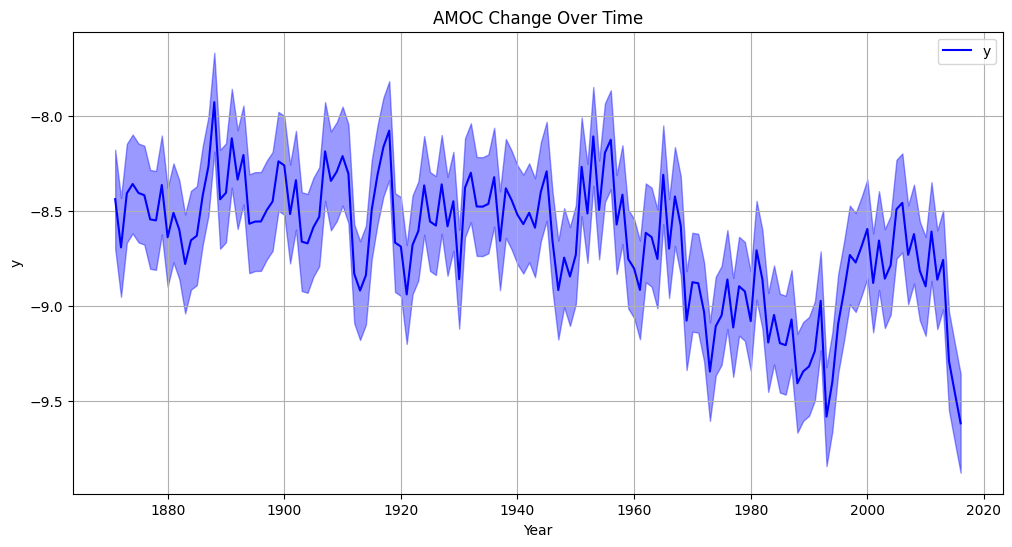

In [10]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(dat['year'], dat['y'], label='y', color='blue')
plt.fill_between(dat['year'], dat['lower'], dat['upper'], color='blue', alpha=0.4)
plt.title('AMOC Change Over Time')
plt.xlabel('Year')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


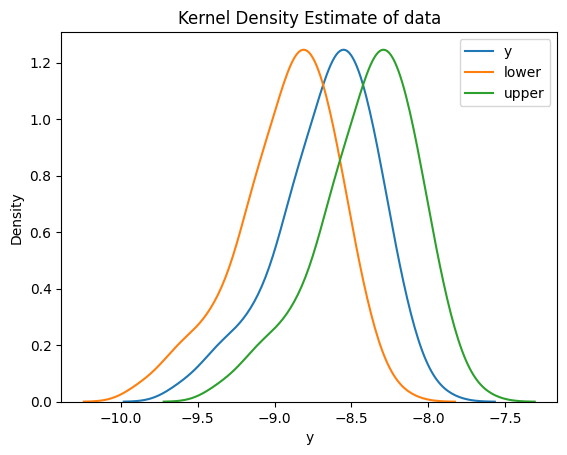

In [11]:
sns.kdeplot(dat, x='y', label='y')
sns.kdeplot(dat, x='lower', label='lower')
sns.kdeplot(dat, x='upper', label='upper')
plt.legend()
plt.title('Kernel Density Estimate of data')
plt.show()

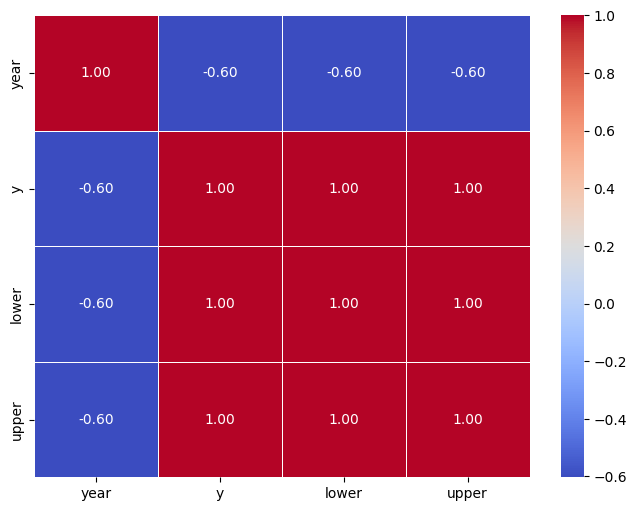

In [12]:
correlation_matrix=dat.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.show()

## **6. Data Preparation**

In [13]:
# Preparing data for the PyMC model
y = dat['y'].values
years = dat['year'].values / 1000  # Scaling years as in the R script
sigma_y = (dat['upper'] - dat['lower']).values / 4
n_obs = len(years)
year_min, year_max = years.min(), years.max()

print(f"Min Year: {year_min}\nMax Year: {year_max}")

Min Year: 1.871
Max Year: 2.016


## **7. Building the Bayesian Model & Sampling from the Posterior**

Here the code defines a Bayesian model with PyMC3. It includes defining priors, the likelihood, and the error model.

In [14]:
# Defining the PyMC model
with pm.Model() as Bmodel:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=2)
    sigma_err = pm.HalfCauchy('sigma_err', beta=2)
    omega = pm.Uniform('omega', lower=year_min, upper=year_max)

    # Model error
    tau = pm.Deterministic('tau', 1 / (sigma_err**2 + sigma_y**2))

    # Likelihood
    idx = years > omega
    mu = pm.math.switch(idx, alpha[1], alpha[0])
    likelihood = pm.Normal('y', mu=mu, tau=tau, observed=y)

    # Sampling
    trace = pm.sample(5000, tune=1000, chains=3, return_inferencedata=False)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


## **8. Model Summary**

In [15]:
# Extracting posterior samples
alpha_samples = trace['alpha']
omega_samples = trace['omega'] * 1000  # Scaling back to original years
sigma_err_samples = trace['sigma_err']

In [16]:
# Calculating summary statistics
summary = pm.summary(trace)
summary

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-8.498,0.025,-8.544,-8.451,0.000,0.000,3901.0,4688.0,1.0
alpha[1],-8.986,0.034,-9.052,-8.922,0.001,0.000,3354.0,4923.0,1.0
sigma_err,0.198,0.017,0.166,0.231,0.000,0.000,3209.0,3952.0,1.0
omega,1.968,0.001,1.967,1.970,0.000,0.000,6822.0,5630.0,1.0
tau[0],17.934,2.166,13.860,21.964,0.039,0.028,3209.0,3952.0,1.0
...,...,...,...,...,...,...,...,...,...
tau[141],17.934,2.166,13.860,21.964,0.039,0.028,3209.0,3952.0,1.0
tau[142],17.934,2.166,13.860,21.964,0.039,0.028,3209.0,3952.0,1.0
tau[143],17.934,2.166,13.860,21.964,0.039,0.028,3209.0,3952.0,1.0
tau[144],17.934,2.166,13.860,21.964,0.039,0.028,3209.0,3952.0,1.0


## **9. Posterior Analysis**

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(*

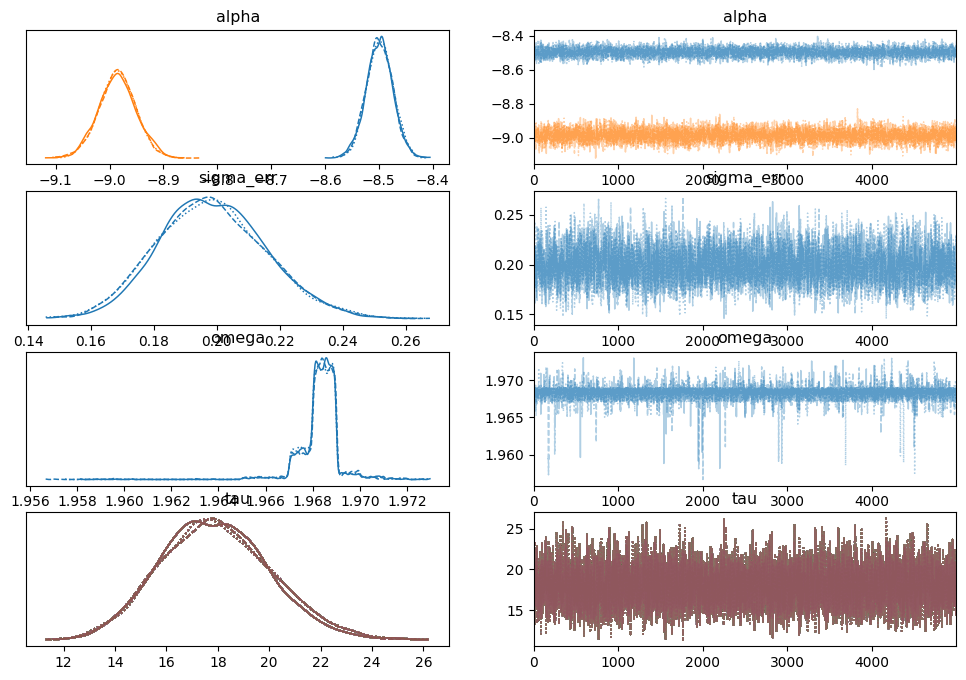

In [17]:
# Plot the trace
az.plot_trace(trace)
plt.show()

## **10. posterior prediction**

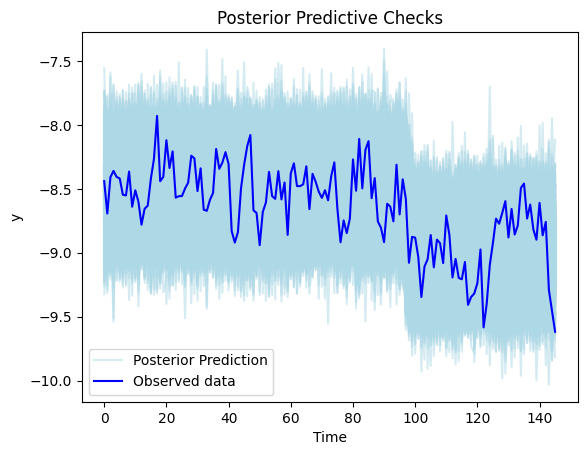

In [18]:
# Plot posterior predictive checks
with Bmodel:
    ppc = pm.sample_posterior_predictive(trace, var_names=['y'])

# Plot the posterior predictive samples
nnn = 0
for i in range(len(ppc['y'][::10])):  # Plot every 10th predicted sample
    if nnn ==0:
      plt.plot(range(len(y)), ppc['y'][i], label='Posterior Prediction', color='lightblue', alpha=0.5)
    else:
      plt.plot(range(len(y)), ppc['y'][i], color='lightblue', alpha=0.5)
    nnn += 1


# Plot the observed data
plt.plot(range(len(y)), y, 'b', label='Observed data')

plt.legend()
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Posterior Predictive Checks')
plt.show()

## **11. Calculating Statistics**

In [19]:
# Creating a summary table
results = {
    "parameter": ["change (omega)", "mean1 (alpha1)", "mean2 (alpha2)", "difference (delta)"],
    "estimate": [summary.loc['omega', 'mean'] * 1000,  # Scaling back to original years
                 summary.loc['alpha[0]', 'mean'],
                 summary.loc['alpha[1]', 'mean'],
                 summary.loc['alpha[1]', 'mean'] - summary.loc['alpha[0]', 'mean']],
    "lower": [summary.loc['omega', 'hdi_3%'] * 1000,  # Scaling back to original years
              summary.loc['alpha[0]', 'hdi_3%'],
              summary.loc['alpha[1]', 'hdi_3%'],
              summary.loc['alpha[1]', 'hdi_3%'] - summary.loc['alpha[0]', 'hdi_97%']],
    "upper": [summary.loc['omega', 'hdi_97%'] * 1000,  # Scaling back to original years
              summary.loc['alpha[0]', 'hdi_97%'],
              summary.loc['alpha[1]', 'hdi_97%'],
              summary.loc['alpha[1]', 'hdi_97%'] - summary.loc['alpha[0]', 'hdi_3%']]
}

results_df = pd.DataFrame(results)

# Display the summary table
print(results_df)

            parameter  estimate     lower     upper
0      change (omega)  1968.000  1967.000  1970.000
1      mean1 (alpha1)    -8.498    -8.544    -8.451
2      mean2 (alpha2)    -8.986    -9.052    -8.922
3  difference (delta)    -0.488    -0.601    -0.378


# **2. AMOC change in mean model (fixed change every 50 years)**

## **1. Importing Libraries**

In [20]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Read in data
dat = pd.read_csv("Caesar.csv")

In [22]:
# arrange by year
dat = dat.sort_values(by='year')

## **2. Initial Data Exploration**

In [23]:
dat.head()

,year,y,lower,upper
0,1871,-8.439521,-8.699521,-8.179521
1,1872,-8.693379,-8.953379,-8.433379
2,1873,-8.408936,-8.668936,-8.148936
3,1874,-8.359843,-8.619843,-8.099843
4,1875,-8.407114,-8.667114,-8.147114


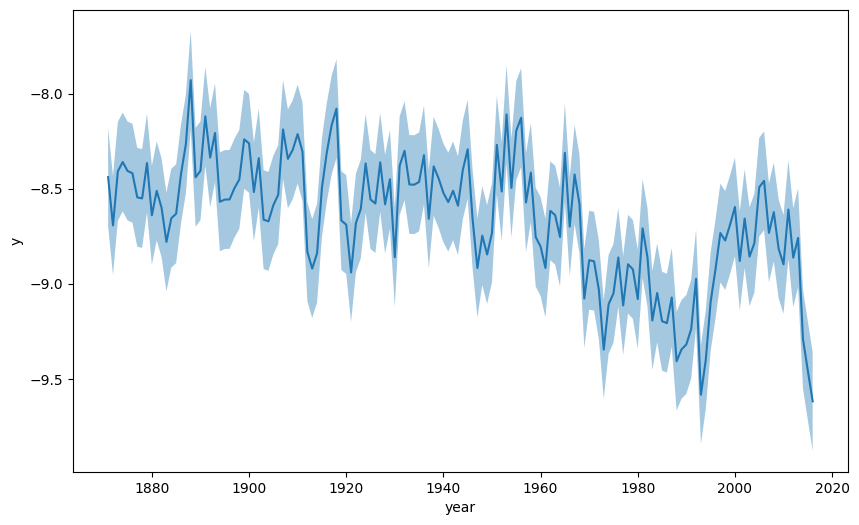

In [24]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x=dat['year'], y=dat['y'])
plt.fill_between(dat['year'], dat['lower'], dat['upper'], alpha=0.4)
plt.show()

## **3. Data Preparation**

In [25]:
# get min and max years
min_year = dat['year'].min()
max_year = dat['year'].max()

print(min_year, max_year)

1871 2016


In [26]:
# observation years
year_j = dat['year']

In [27]:
# get the vector of change points
changes = np.sort(np.arange(max_year, min_year, -50))

if changes[0] != min_year:
    if changes[0] - min_year > 10:
        changes = np.insert(changes, 0, min_year)
    else:
        changes[0] = min_year

In [28]:
# get no. of changes
n_changes = len(changes) - 1
# no. of obs
n = len(dat['year'])

In [29]:
# get mean indexes for each obs (depending on change point)
alpha_index = np.empty(n)
names = []

for j in range(n_changes):
    for i in range(n):
        alpha_index[i] = j if changes[j] <= dat['year'].iloc[i] < changes[j+1] else alpha_index[i]
    names.append(f"{int(changes[j])}-{int(changes[j+1])-1}")

alpha_index[-1] = n_changes
names[0] = f"{int(changes[0])}-{int(changes[1])}"

## **4. Building the Bayesian Model for 50 year interval**

In [30]:
# Adjust alpha_index to ensure it's within bounds
alpha_index_adjusted = np.clip(alpha_index.astype(int), 0, n_changes - 1)

# Define the PyMC3 model
with pm.Model() as model:
    interval_mean = pm.Normal('interval_mean', mu=0, sd=1, shape=n_changes)
    sigma_err = pm.HalfNormal('sigma_err', sd=1)
    tau = 1 / (sigma_err**2 + ((dat['upper'] - dat['lower']) / 4)**2)

    # Data likelihood
    y_obs = pm.Normal('y_obs', mu=interval_mean[alpha_index_adjusted], sd=tau, observed=dat['y'])

    # Sampling
    trace = pm.sample(5000, tune=1000, return_inferencedata=False)

<ipython-input-31-8bd702984cc0>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, figsize=(12, 6))  # Adjust figure size as needed
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


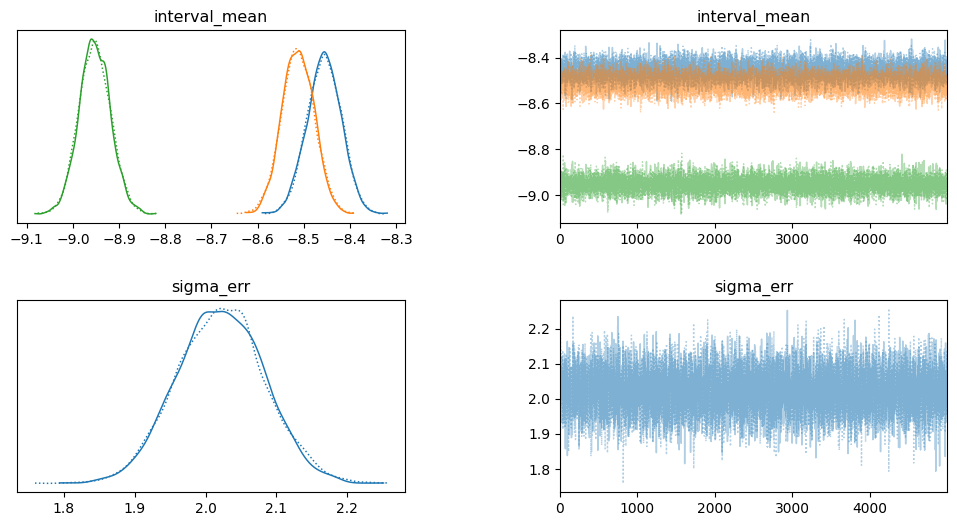

In [31]:
# Plotting the trace
pm.traceplot(trace, figsize=(12, 6))  # Adjust figure size as needed
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [32]:
# Posterior analysis
alpha_samps = pd.DataFrame({name: trace['interval_mean'][:,i] for i, name in enumerate(names)})
alpha_dat = alpha_samps.melt(var_name='interval', value_name='value')

alpha_summary = alpha_dat.groupby('interval')['value'].agg(['mean', lambda x: np.quantile(x, 0.025), lambda x: np.quantile(x, 0.975)])
alpha_summary.columns = ['est', 'lwr', 'upr']

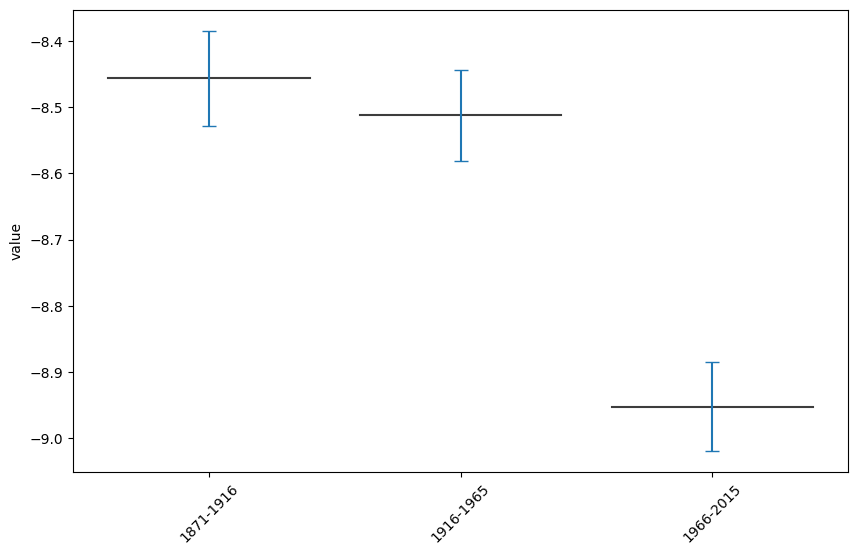

In [33]:
# Plot the mean estimates and uncertainty
plt.figure(figsize=(10, 6))
sns.violinplot(data=alpha_summary.reset_index(), x='interval', y='est')
plt.errorbar(x=alpha_summary.index, y=alpha_summary['est'], yerr=[alpha_summary['est'] - alpha_summary['lwr'], alpha_summary['upr'] - alpha_summary['est']], fmt='none', capsize=5)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('value')
plt.show()

## **5. Model Summary**

In [34]:
# Calculating summary statistics
summary = pm.summary(trace)
print(summary)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
interval_mean[0] -8.456  0.037  -8.525   -8.387      0.000      0.0   15045.0   
interval_mean[1] -8.512  0.035  -8.579   -8.448      0.000      0.0   15673.0   
interval_mean[2] -8.953  0.034  -9.015   -8.888      0.000      0.0   16037.0   
sigma_err         2.021  0.062   1.908    2.138      0.001      0.0   13837.0   

                  ess_tail  r_hat  
interval_mean[0]    7760.0    1.0  
interval_mean[1]    7222.0    1.0  
interval_mean[2]    7478.0    1.0  
sigma_err           7654.0    1.0  


# **3. Frequentist Model for AMOC Change in Mean - (Single Estimated change model)**

## **1. Importing Libraries**

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

## **2. Loading the Data**

In [36]:
# Read in data
data = pd.read_csv("Caesar.csv")

## **3. Initial Data Exploration**

In [37]:
data.head()

,year,y,lower,upper
0,1871,-8.439521,-8.699521,-8.179521
1,1872,-8.693379,-8.953379,-8.433379
2,1873,-8.408936,-8.668936,-8.148936
3,1874,-8.359843,-8.619843,-8.099843
4,1875,-8.407114,-8.667114,-8.147114


## **4. Data Preparation for Non-Linear Model**

In [38]:
# Adding a column for the square of the 'year' to implement a quadratic model
data['year_squared'] = data['year'] ** 2

# Defining the independent variables (including the squared term) and the dependent variable
X = data[['year', 'year_squared']]
y = data['y']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

## **5. Fitting the Non-Linear Model**

In [39]:
# Fitting a quadratic regression model
model = sm.OLS(y, X).fit()

## **6. Model Summary**

In [40]:
# Summary of the model
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     45.29
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           5.82e-16
Time:                        07:12:17   Log-Likelihood:                -8.4447
No. Observations:                 146   AIC:                             22.89
Df Residuals:                     143   BIC:                             31.84
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -120.9798     50.962     -2.374   

## **7. Visualization of Model Forecast**

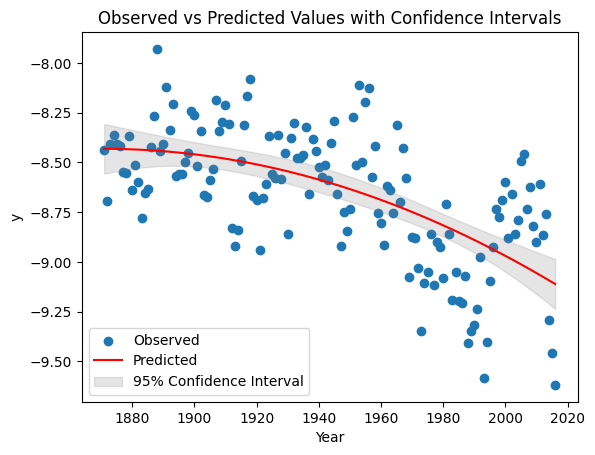

In [41]:
# Predicted values
data['predicted_y'] = model.predict(X)

# Calculating confidence intervals for the predictions
predictions = model.get_prediction(X)
intervals = predictions.conf_int()

# Plotting the observed vs. predicted values
plt.scatter(data['year'], data['y'], label='Observed')
plt.plot(data['year'], data['predicted_y'], color='red', label='Predicted')

# Plotting confidence intervals
plt.fill_between(data['year'], intervals[:, 0], intervals[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Year')
plt.ylabel('y')
plt.title('Observed vs Predicted Values with Confidence Intervals')
plt.legend()
plt.show()

## **8. Calculating Statistics for Model Parameters**

In [42]:
# Extracting model parameters, standard errors, confidence intervals, and p-values
params = model.params
conf = model.conf_int()
pvalues = model.pvalues
std_err = model.bse

# Creating a DataFrame to store these statistics
results_df = pd.DataFrame({
    'parameter': params.index,
    'estimate': params.values,
    'std_error': std_err.values,
    'lower_95%': conf[0].values,
    'upper_95%': conf[1].values,
    'p_value': pvalues.values
})

# Print the table
print(results_df.to_string(index=False))

   parameter    estimate  std_error   lower_95%  upper_95%  p_value
       const -120.979753  50.961552 -221.715056 -20.244450 0.018928
        year    0.120331   0.052460    0.016634   0.224029 0.023261
year_squared   -0.000032   0.000013   -0.000059  -0.000005 0.018476


# **4. Frequentist Model for AMOC Change in Mean - (50 year fixed)**

## **1. Importing Libraries**

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

## **2. Loading the Data**

In [44]:
# Read in data
data = pd.read_csv("Caesar.csv")

## **3. Data Preparation**

In [45]:
# Defining intervals for AMOC change (every 50 years)
min_year = data['year'].min()
max_year = data['year'].max()
change_points = list(range(min_year, max_year + 1, 50))

In [46]:
# Create a new column to indicate the period
data['period'] = np.digitize(data['year'], bins=change_points, right=False)

In [47]:
# One-hot encode the period column
data = pd.get_dummies(data, columns=['period'], drop_first=True)

## **4. Fitting the Linear Model**

In [48]:
# Independent variables
X = data.drop(['y', 'lower', 'upper', 'year'], axis=1)

In [49]:
# Dependent variable
y = data['y']

In [50]:
# Adding a constant to the model (intercept)
X = sm.add_constant(X)

In [51]:
# Fit the model
model = sm.OLS(y, X).fit()

In [52]:
# **5. Model Summary**
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     66.04
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           4.86e-21
Time:                        07:13:17   Log-Likelihood:                 3.4942
No. Observations:                 146   AIC:                           -0.9883
Df Residuals:                     143   BIC:                             7.962
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4586      0.034   -250.558      0.0

## **5. Visualization of Model Forecast**

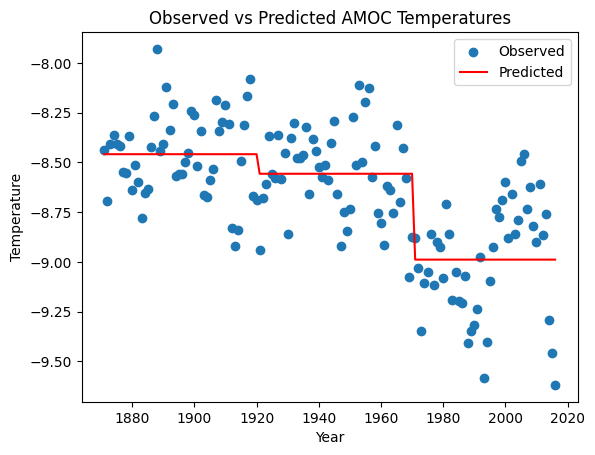

In [53]:
# Predicted values
data['predicted_y'] = model.predict(X)

# Plotting observed vs. predicted values
plt.scatter(data['year'], data['y'], label='Observed')
plt.plot(data['year'], data['predicted_y'], color='red', label='Predicted')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Observed vs Predicted AMOC Temperatures')
plt.legend()
plt.show()

## **6. Extracting and Displaying Model Statistics**


In [54]:
# Extracting model parameters, standard errors, confidence intervals, and p-values
params = model.params
conf = model.conf_int()
pvalues = model.pvalues
std_err = model.bse

# Creating a DataFrame to store these statistics
results_df = pd.DataFrame({
    'parameter': params.index,
    'estimate': params.values,
    'std_error': std_err.values,
    'lower_95%': conf[0].values,
    'upper_95%': conf[1].values,
    'p_value': pvalues.values
})

# Print the table
print(results_df.to_string(index=False))

parameter  estimate  std_error  lower_95%  upper_95%       p_value
    const -8.458649   0.033759  -8.525380  -8.391917 6.545617e-191
 period_2 -0.098371   0.047743  -0.192744  -0.003998  4.116876e-02
 period_3 -0.530007   0.048770  -0.626409  -0.433604  1.979634e-20
